# Variational Autoencoders

In [ ]:
%cd "../"

In [46]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
import numpy as np
import os
import random
import time

### Set hyperparameters

In [47]:
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 15
NUM_CLASSES = 10

In [4]:
def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    torch.set_deterministic(True)
    
    
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [5]:
set_deterministic
set_all_seeds(RANDOM_SEED)

### Prepare dataset

In [6]:
def get_dataloaders_mnist(batch_size, num_workers=0, validation_fraction=None, train_transforms=None, test_transforms=None):

    if train_transforms is None:
        train_transforms = transforms.ToTensor()

    if test_transforms is None:
        test_transforms = transforms.ToTensor()

    train_dataset = datasets.MNIST(root='data',
                                   train=True,
                                   transform=train_transforms,
                                   download=True)

    valid_dataset = datasets.MNIST(root='data',
                                   train=True,
                                   transform=test_transforms)

    test_dataset = datasets.MNIST(root='data',
                                  train=False,
                                  transform=test_transforms)

    if validation_fraction is not None:
        num = int(validation_fraction * 60000)
        train_indices = torch.arange(0, 60000 - num)
        valid_indices = torch.arange(60000 - num, 60000)

        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(valid_indices)

        valid_loader = DataLoader(dataset=valid_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  sampler=valid_sampler)

        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  drop_last=True,
                                  sampler=train_sampler)
    else:
        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  shuffle=True)

    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)

    if validation_fraction is None:
        return train_loader, test_loader
    else:
        return train_loader, valid_loader, test_loader


In [7]:
train_loader, valid_loader, test_loader = get_dataloaders_mnist(
    batch_size=BATCH_SIZE, 
    num_workers=2, 
    validation_fraction=0.
)

In [8]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([1, 2, 1, 9, 0, 6, 9, 8, 0, 1])

Validation Set:

Testing Set:
Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


### Implement architecture

In [9]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]
    

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.relu1 = nn.LeakyReLU(0.01)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, stride=2, kernel_size=3, padding=1)
        self.relu2 = nn.LeakyReLU(0.01)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, stride=2, kernel_size=3, padding=1)
        self.relu3 = nn.LeakyReLU(0.01)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, stride=1, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.conv4(x)
        x = self.flatten(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear = nn.Linear(in_features=2, out_features=3136)
        self.trans_conv1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, stride=1, kernel_size=3, padding=1)
        self.relu1 = nn.LeakyReLU(0.01)
        self.trans_conv2 = nn.ConvTranspose2d(in_channels=64, out_channels=64, stride=2, kernel_size=3, padding=1)
        self.relu2 = nn.LeakyReLU(0.01)
        self.trans_conv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, stride=2, kernel_size=3, padding=0)                
        self.relu3 = nn.LeakyReLU(0.01)
        self.trans_conv4 = nn.ConvTranspose2d(in_channels=32, out_channels=1, stride=1, kernel_size=3, padding=0)        
        self.trim = Trim()
        self.out = nn.Sigmoid()

        
    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 64, 7, 7)
        x = self.relu1(self.trans_conv1(x))
        x = self.relu2(self.trans_conv2(x))
        x = self.relu3(self.trans_conv3(x))
        x = self.trans_conv4(x)
        x = self.trim(x)
        x = self.out(x)
        return x

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.z_mean = torch.nn.Linear(3136, 2)
        self.z_log_var = torch.nn.Linear(3136, 2)        
        

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).cuda()
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        decoded = self.out(decoded)
        return encoded, z_mean, z_log_var, decoded

In [10]:
x = torch.randn(1, 1, 28, 28).cuda()
model = VAE().cuda()
encoded, z_mean, z_log_var, decoded = model(x)

In [11]:
image = Image.open("samples/cock.jpg").resize((28, 28))
image = np.array(image)[:,:,0]
x = torch.tensor(image).unsqueeze(0).unsqueeze(0).to(torch.float32).cuda()
_, _, _, decoded = model(x)

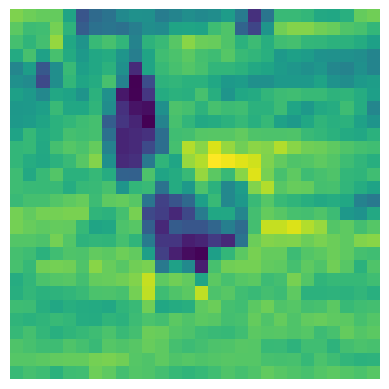

In [12]:
plt.axis("off")
plt.imshow(image)
plt.show()

### Start training

In [18]:
set_all_seeds(RANDOM_SEED)
model = VAE().cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)  

In [14]:
def compute_epoch_loss_autoencoder(model, data_loader, loss_fn):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for input, _ in data_loader:
            input = input.cuda()
            _, _, _, logits = model(input)
            loss = loss_fn(logits, input, reduction='sum')
            num_examples += input.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

In [15]:
def training_loop(num_epochs, model, optimizer, train_loader, loss_fn=None, logging_interval=100, 
                  skip_epoch_stats=False, reconstruction_term_weight=1, save_path=None):
    
    log_dict = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}
    
    if loss_fn is None:
        loss_fn = F.mse_loss
        
    start_time = time.time()
    min_loss = 1000
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (input, target) in enumerate(train_loader):
            input = input.cuda()
            encoded, z_mean, z_log_var, decoded = model(input)
            kl_div = -0.5 * torch.sum(1 + z_log_var - z_mean**2 - torch.exp(z_log_var), axis=1)
            batchsize = kl_div.size(0)
            kl_div = kl_div.mean()
            pixelwise = loss_fn(decoded, input, reduction='none')
            pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) 
            pixelwise = pixelwise.mean()
            loss = reconstruction_term_weight*pixelwise + kl_div
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            log_dict['train_combined_loss_per_batch'].append(loss.item())
            log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
            log_dict['train_kl_loss_per_batch'].append(kl_div.item())
            
            if not batch_idx % logging_interval:
                print('=> Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'% (epoch+1, num_epochs, batch_idx,len(train_loader), loss))
                
        if not skip_epoch_stats:
            model.eval()            
            with torch.set_grad_enabled(False):
                train_loss = compute_epoch_loss_autoencoder(model, train_loader, loss_fn)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (epoch+1, num_epochs, train_loss))
                log_dict['train_combined_loss_per_epoch'].append(train_loss.item())
                if train_loss < min_loss:
                    min_loss = train_loss
                    torch.save(model.state_dict(), save_path)
                
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
        
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    return log_dict

In [19]:
log_dict = training_loop(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer=optimizer, 
                        train_loader=train_loader,
                        skip_epoch_stats=False,
                        logging_interval=50,
                        save_path=".cache/models/vae.pt")

=> Epoch: 001/015 | Batch 0000/0234 | Loss: 254.9521
=> Epoch: 001/015 | Batch 0050/0234 | Loss: 60.2262
=> Epoch: 001/015 | Batch 0100/0234 | Loss: 52.9193
=> Epoch: 001/015 | Batch 0150/0234 | Loss: 54.9564
=> Epoch: 001/015 | Batch 0200/0234 | Loss: 50.7476
***Epoch: 001/015 | Loss: 47.065
Time elapsed: 0.17 min
=> Epoch: 002/015 | Batch 0000/0234 | Loss: 49.3378
=> Epoch: 002/015 | Batch 0050/0234 | Loss: 47.2635
=> Epoch: 002/015 | Batch 0100/0234 | Loss: 47.7713
=> Epoch: 002/015 | Batch 0150/0234 | Loss: 46.2942
=> Epoch: 002/015 | Batch 0200/0234 | Loss: 47.1342
***Epoch: 002/015 | Loss: 42.288
Time elapsed: 0.33 min
=> Epoch: 003/015 | Batch 0000/0234 | Loss: 46.8975
=> Epoch: 003/015 | Batch 0050/0234 | Loss: 44.2888
=> Epoch: 003/015 | Batch 0100/0234 | Loss: 44.3486
=> Epoch: 003/015 | Batch 0150/0234 | Loss: 43.2793
=> Epoch: 003/015 | Batch 0200/0234 | Loss: 42.6861
***Epoch: 003/015 | Loss: 39.216
Time elapsed: 0.51 min
=> Epoch: 004/015 | Batch 0000/0234 | Loss: 42.5861

### Plotting

In [37]:
def plot_training_loss(minibatch_losses, num_epochs, averaging_iterations=100, custom_label=''):

    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_losses)), (minibatch_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    ax1.set_ylim([0, np.max(minibatch_losses[num_losses:])*1.5])

    ax1.plot(
        np.convolve(
            minibatch_losses,
            np.ones(averaging_iterations,)/averaging_iterations,
            mode='valid'
        ),
        label=f'Running Average{custom_label}')
    ax1.legend()

    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    
    plt.tight_layout()

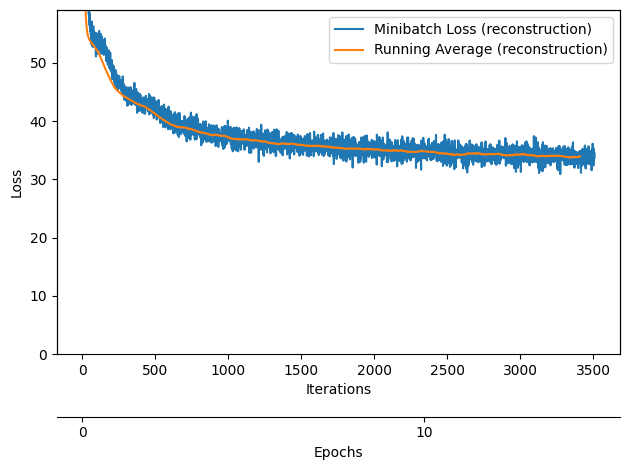

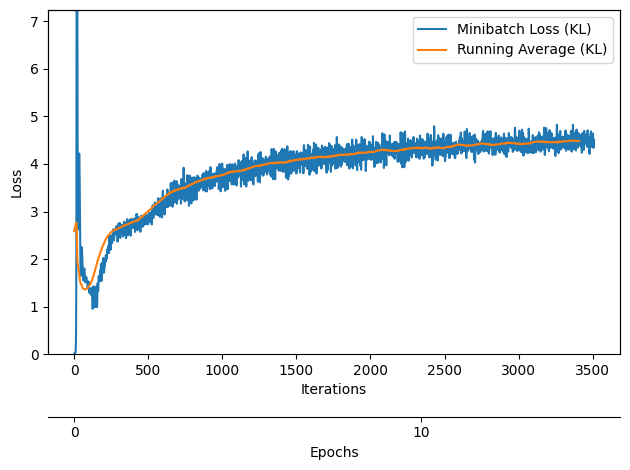

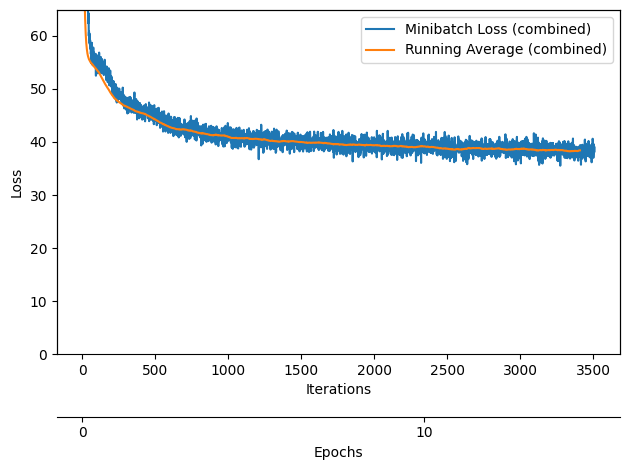

In [38]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()

### Visualization

#### Plot generated images

In [40]:
def plot_generated_images(data_loader, model, unnormalizer=None, figsize=(20, 2.5), n_images=15, modeltype='autoencoder'):

    fig, axes = plt.subplots(nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=figsize)
    
    for batch_idx, (input, _) in enumerate(data_loader):
        input = input.cuda()
        color_channels = input.shape[1]
        image_height = input.shape[2]
        image_width = input.shape[3]
        
        with torch.no_grad():
            if modeltype == 'autoencoder':
                decoded_images = model(input)[:n_images]
            elif modeltype == 'VAE':
                encoded, z_mean, z_log_var, decoded_images = model(input)[:n_images]
            else:
                raise ValueError('`modeltype` not supported')

        orig_images = input[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().cpu()
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax[i].imshow(curr_img)
            else:
                ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')

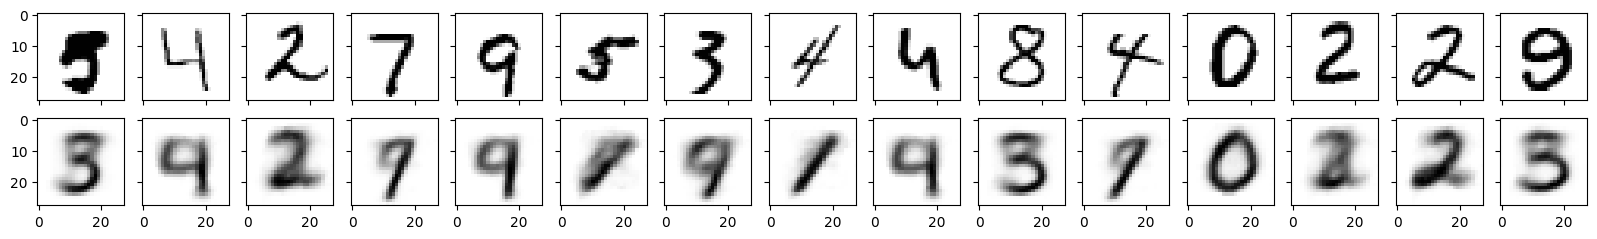

In [41]:
plot_generated_images(data_loader=train_loader, model=model, modeltype='VAE')   

#### Plot 2D latent space

In [48]:
def plot_latent_space_with_labels(num_classes, data_loader, encoding_fn):
    d = {i:[] for i in range(num_classes)}

    with torch.no_grad():
        for i, (input, targets) in enumerate(data_loader):

            input = input.cuda()
            targets = targets.cuda()
            
            embedding = encoding_fn(input)

            for i in range(num_classes):
                if i in targets:
                    mask = targets == i
                    d[i].append(embedding[mask].cpu().numpy())

    colors = list(mcolors.TABLEAU_COLORS.items())
    for i in range(num_classes):
        d[i] = np.concatenate(d[i])
        plt.scatter(
            d[i][:, 0], d[i][:, 1],
            color=colors[i][1],
            label=f'{i}',
            alpha=0.5)

    plt.legend()

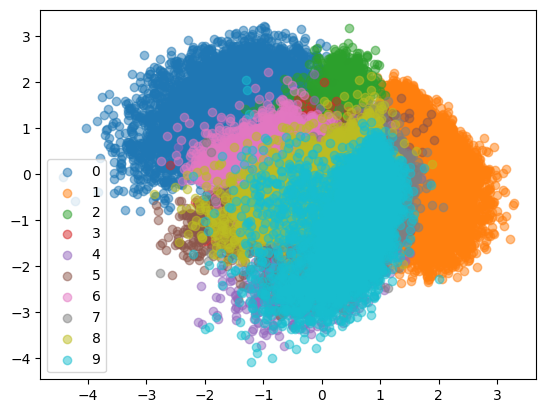

In [49]:
plot_latent_space_with_labels(
    num_classes=NUM_CLASSES,
    data_loader=train_loader,
    encoding_fn=model.encoding_fn
)

plt.legend()
plt.show()

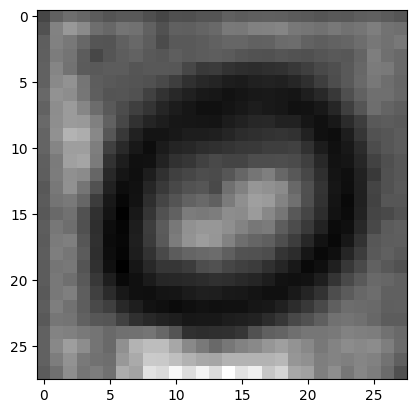

In [55]:
with torch.no_grad():
    new_image = model.decoder(torch.tensor([-3, 2.]).cuda())
    new_image.squeeze_(0)
    new_image.squeeze_(0)
    
plt.imshow(new_image.to('cpu').numpy(), cmap='binary')
plt.show()

In [56]:
def plot_images_sampled_from_vae(model, latent_size, unnormalizer=None, num_images=10):

    with torch.no_grad():

        # random sample
        rand_input = torch.randn(num_images, latent_size).cuda()
        new_images = model.decoder(rand_input)
        color_channels = new_images.shape[1]
        image_height = new_images.shape[2]
        image_width = new_images.shape[3]

        # visualization
        image_width = 28
        fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(10, 2.5), sharey=True)
        decoded_images = new_images[:num_images]

        for ax, img in zip(axes, decoded_images):
            curr_img = img.detach().cpu()
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax.imshow(curr_img)
            else:
                ax.imshow(curr_img.view((image_height, image_width)), cmap='binary') 

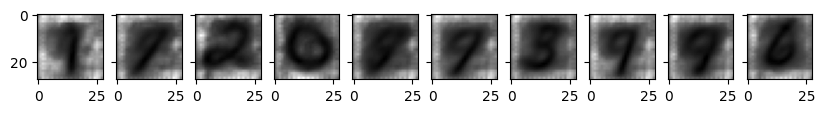

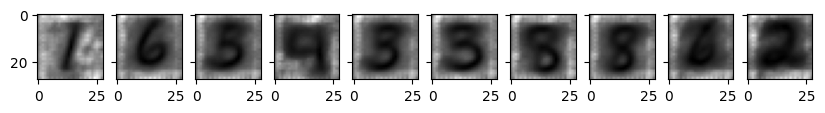

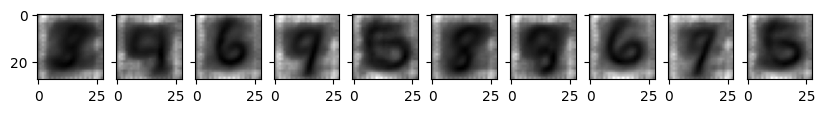

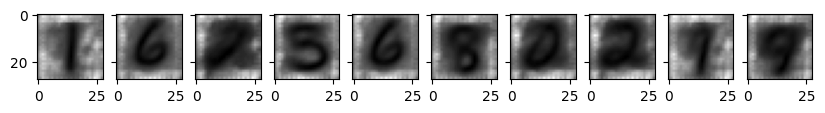

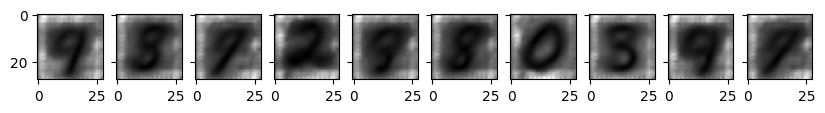

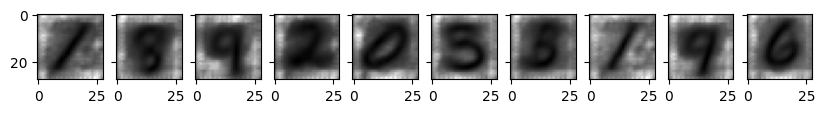

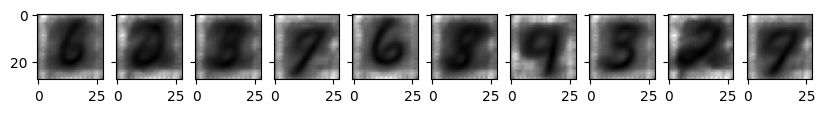

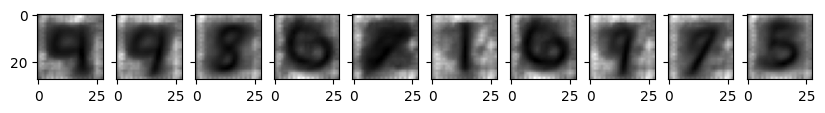

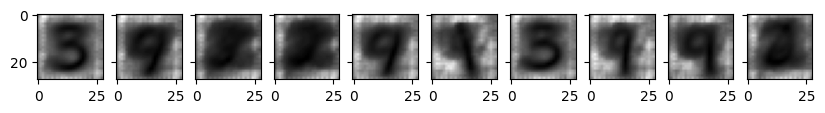

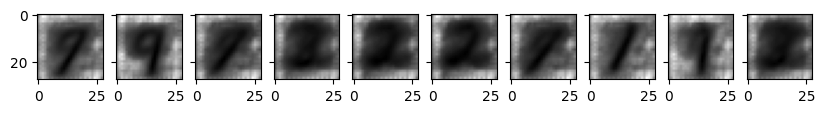

In [57]:
for i in range(10):
    plot_images_sampled_from_vae(model=model, latent_size=2)
    plt.show()